# Introduction

Author: Harneet Rishi

Purpose: Generate figures for TFBS analysis

# Imports

## Modules/packages

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches
%matplotlib inline
import seaborn as sns

import random
import statsmodels.stats.multitest as smm
from scipy.special import comb
from scipy.stats import hypergeom, pearsonr, mannwhitneyu, sem

import warnings
warnings.filterwarnings('ignore')

## Functions

### Stats

In [2]:
def calc_pooled_var(n1, var1, n2, var2):
    pooled_var = np.sqrt( ((n1 - 1)*var1 + (n2-1)*var2) / (n1 + n2 - 2) )
    return pooled_var

In [3]:
def calc_cohens_d(mean_x, mean_y, pooled_var):
    cohens_d = (mean_x - mean_y) / pooled_var
    return abs(cohens_d)

### Mini Genome Browser Viz Functions

#### Plot graphics

In [4]:
def plot_gene_patch_2(df, ax, color):
    strand = df['(6) DNA strand where gene is coded'].values
    xmin = df['(4) Gene_pos_left'].values
    xmax = df['(5) Gene_pos_right'].values
    
    if strand == 'forward':
        strand_factor = 1
        p1 = [xmin, 0]
        p2 = [xmin, 2*strand_factor]
        p3 = [xmax - 25, 2*strand_factor]
        p4 = [xmax, strand_factor]
        p5 = [xmax - 25, 0]
    else:
        strand_factor = -1
        p1 = [xmin + 25, 0]
        p2 = [xmax, 0]
        p3 = [xmax, 2*strand_factor]
        p4 = [xmin + 25, 2*strand_factor]
        p5 = [xmin, strand_factor]
            
    verts = [p1, p2, p3, p4, p5, (0,0)]
    codes = [Path.MOVETO, Path.LINETO, Path.LINETO, Path.LINETO, Path.LINETO, Path.CLOSEPOLY]
    path = Path(verts, codes)
    patch = patches.PathPatch(path, facecolor = color, lw = 1, edgecolor = 'gray')
    ax.add_patch(patch)
    
    return

In [5]:
def plot_promoter_patch(df_promoter, ax, scale):
    TSS_pos_genome = df_promoter.iloc[0]['(4) Genome map position of TSS (+1)']
    promoter_strand_genome = df_promoter.iloc[0]['(3) DNA strand where promoter is loc']
    if promoter_strand_genome == 'forward':
        p1 = [TSS_pos_genome - 60, 0]
        p2 = [TSS_pos_genome - 60, 3]
        p3 = [TSS_pos_genome, 3]
        arrow = '>'
    else:
        p1 = [TSS_pos_genome + 60, 0]
        p2 = [TSS_pos_genome + 60, -3]
        p3 = [TSS_pos_genome, -3]
        arrow = '<'
    
    verts = [p1, p2, p3]
    codes = [Path.MOVETO, Path.LINETO, Path.LINETO]
    path = Path(verts, codes)
    patch = patches.PathPatch(path, facecolor='none', lw=2, edgecolor  = 'gray')
    ax.add_patch(patch)
    ax.plot(verts[-1][0], verts[-1][1], arrow, lw=2, color = 'gray', markeredgecolor = 'gray', ms = scale)
    return

In [6]:
def plot_promoter_patch_withoffset(df_promoter, ax, scale):
    TSS_pos_genome = df_promoter.iloc[0]['(4) Genome map position of TSS (+1)'] + annotation_offset
    promoter_strand_genome = df_promoter.loc[0]['(3) DNA strand where promoter is loc']
    if promoter_strand_genome == 'forward':
        p1 = [TSS_pos_genome - 60, 0]
        p2 = [TSS_pos_genome - 60, 3]
        p3 = [TSS_pos_genome, 3]
        arrow = '>'
    else:
        p1 = [TSS_pos_genome + 60, 0]
        p2 = [TSS_pos_genome + 60, -3]
        p3 = [TSS_pos_genome, -3]
        arrow = '<'
    
    verts = [p1, p2, p3]
    codes = [Path.MOVETO, Path.LINETO, Path.LINETO]
    path = Path(verts, codes)
    patch = patches.PathPatch(path, facecolor='none', lw=2, edgecolor  = 'gray')
    ax.add_patch(patch)
    ax.plot(verts[-1][0], verts[-1][1], arrow, lw=2, color = 'gray', markeredgecolor = 'gray', ms = scale)
    return

In [7]:
def plot_TFBS_patch(df, ax, annotation_offset, strand):
    ECK = df['ECK'].unique()
    xmin = BindingSiteSet2018.loc[ECK]['(4) TF-bs left end position in the genome'].unique()
    xmax = BindingSiteSet2018.loc[ECK]['(5) TF-bs right end position in the genome'].unique()
    effect = BindingSiteSet2018.loc[ECK]['(9) Gene expression effect caused by the TF bound to the  TF-bs (+ activation, - repression, +- dual, ? unknown)'].unique()
    
    if len(effect) > 1:
        effect = '+-'
    
    xmin = xmin + annotation_offset
    xmax = xmax + annotation_offset
        
    dict_TFBSexpressionColor = {'+': sns.color_palette('deep')[1],
                                '-': sns.color_palette('deep')[2],
                                '+-': 'gray'}
    
    if strand == 'forward':
        strand_factor = 1
        p1 = [xmin, 0]
        p2 = [xmin, 2*strand_factor]
        p3 = [xmax, 2*strand_factor]
        p4 = [xmax, 0]
    else:
        strand_factor = -1
        p1 = [xmin, 0]
        p2 = [xmax, 0]
        p3 = [xmax, 2*strand_factor]
        p4 = [xmin, 2*strand_factor]
            
    verts = [p1, p2, p3, p4, (0,0)]
    codes = [Path.MOVETO, Path.LINETO, Path.LINETO, Path.LINETO, Path.CLOSEPOLY]
    path = Path(verts, codes)
    patch = patches.PathPatch(path, facecolor = 'gray', lw = 1, edgecolor = 'black')
    ax.add_patch(patch)
    
    return

In [8]:
def plot_TFBS_patch_v2(ECK, ax, annotation_offset, strand):
    xmin = BindingSiteSet2018.loc[ECK]['(4) TF-bs left end position in the genome'].unique()
    xmax = BindingSiteSet2018.loc[ECK]['(5) TF-bs right end position in the genome'].unique()
    effect = BindingSiteSet2018.loc[ECK]['(9) Gene expression effect caused by the TF bound to the  TF-bs (+ activation, - repression, +- dual, ? unknown)'].unique()
    
    if len(effect) > 1:
        effect = '+-'
    
    xmin = xmin + annotation_offset
    xmax = xmax + annotation_offset
        
    dict_TFBSexpressionColor = {'+': sns.color_palette('deep')[1],
                                '-': sns.color_palette('deep')[2],
                                '+-': 'gray'}
    
    if strand == 'forward':
        strand_factor = 1
        p1 = [xmin, 0]
        p2 = [xmin, 2*strand_factor]
        p3 = [xmax, 2*strand_factor]
        p4 = [xmax, 0]
    else:
        strand_factor = -1
        p1 = [xmin, 0]
        p2 = [xmax, 0]
        p3 = [xmax, 2*strand_factor]
        p4 = [xmin, 2*strand_factor]
            
    verts = [p1, p2, p3, p4, (0,0)]
    codes = [Path.MOVETO, Path.LINETO, Path.LINETO, Path.LINETO, Path.CLOSEPOLY]
    path = Path(verts, codes)
    patch = patches.PathPatch(path, facecolor = 'gray', lw = 1, edgecolor = 'black')
    ax.add_patch(patch)
    
    return

In [9]:
def plot_TFBS_patch_v3(ECK, ax, annotation_offset, strand):
    df = BindingSiteSet2018.loc[ECK]
    
    if type(df) == pd.core.series.Series:
        xmin = df['(4) TF-bs left end position in the genome']
        xmax = df['(5) TF-bs right end position in the genome']
        effect = df['(9) Gene expression effect caused by the TF bound to the  TF-bs (+ activation, - repression, +- dual, ? unknown)']
    else:
        xmin = df.loc[ECK]['(4) TF-bs left end position in the genome'].unique()
        xmax = df.loc[ECK]['(5) TF-bs right end position in the genome'].unique()
        effect = df.loc[ECK]['(9) Gene expression effect caused by the TF bound to the  TF-bs (+ activation, - repression, +- dual, ? unknown)'].unique()
    
    xmin = xmin + annotation_offset
    xmax = xmax + annotation_offset
        
    dict_TFBSexpressionColor = {'+': sns.color_palette('deep')[1],
                                '-': sns.color_palette('deep')[2],
                                '+-': 'gray'}
    
    if strand == 'forward':
        strand_factor = 1
        p1 = [xmin, 0]
        p2 = [xmin, 2*strand_factor]
        p3 = [xmax, 2*strand_factor]
        p4 = [xmax, 0]
    else:
        strand_factor = -1
        p1 = [xmin, 0]
        p2 = [xmax, 0]
        p3 = [xmax, 2*strand_factor]
        p4 = [xmin, 2*strand_factor]
            
    verts = [p1, p2, p3, p4, (0,0)]
    codes = [Path.MOVETO, Path.LINETO, Path.LINETO, Path.LINETO, Path.CLOSEPOLY]
    path = Path(verts, codes)
    patch = patches.PathPatch(path, facecolor = '#D1D2D4', lw = 1, edgecolor = 'gray')
    ax.add_patch(patch)
    
    return

#### Get TFBS information

In [10]:
def get_TFBS_info(TU_name):
    df = df_TFBSpromFit[df_TFBSpromFit['TUs'] == TU]
    df_TFBS = df[df['ET165_LB_ae_t0'] >= 10]

    return df_TFBS

In [11]:
def get_TFBS_annot(TU_name):
    TU = TU_name.split("'")[1].split("'")[0]
    df = BindingSiteSet2018[BindingSiteSet2018['(8) Transcription unit regulated by the TF'].str.contains(TU)]
    return df

#### Plot guides

In [12]:
dict_condition_t0 = {'LB_ae_avgLR_nmed': 'ET165_LB_ae_t0',
                     'LB_an_avgLR_nmed': 'ET165_LB_an_t0',
                     'M9Ca_ae_avgLR_nmed': 'M9_t0_BR2_glu+gly',
                     'M9_ae_avgLR_nmed': 'M9_t0_BR2_glu+gly'}

In [13]:
def plot_gene_sgRNAs(sgRNA, condition):
    sgRNA_pos = df_sgRNA_info_update_3.loc[sgRNA]['pos'] + annotation_offset
    DNAstrandsgRNA = df_sgRNA_info_update_3.loc[sgRNA]['strand']
    Fitness = df_LRs_GEq_2e6_nmed_selcols.loc[sgRNA][condition]
    plt.plot([sgRNA_pos+10], [Fitness], 'v', label = 'sgRNA', color = colors[i], ms = 4, mew=0.5, mec='k')
    
    return

In [14]:
def plot_promoter_sgRNAs(sgRNA, condition):
    sgRNA_pos = df_sgRNA_info_update_3.loc[sgRNA]['pos'] + annotation_offset
    DNAstrandsgRNA = df_sgRNA_info_update_3.loc[sgRNA]['strand']
    Fitness = df_LRs_GEq_2e6_nmed_selcols.loc[sgRNA][condition]
    x = df_map_ann_PromInTUSet_dropnapromotername[df_map_ann_PromInTUSet_dropnapromotername['sgRNA seq'] == sgRNA]
    if len(x) > 1:
        sgRNAProm_mapping = x['mapping orientation'].unique()[0]
    else:
        sgRNAProm_mapping = x['mapping orientation'].values[0]
        
    if sgRNAProm_mapping == 'for map':
        plt.plot([sgRNA_pos+10], [Fitness], '^', label = 'sgRNA', color =  '#AE282B', ms = 4, mew=0.5, mec='k')
    else:
        plt.plot([sgRNA_pos+10], [Fitness], 'v', label = 'sgRNA', color =  '#AE282B', ms = 4, mew=0.5, mec='k')  
        
    return

In [15]:
def plot_TFBS_sgRNAs(sgRNA, condition):
    sgRNA_pos = df_sgRNA_info_update_3.loc[sgRNA]['pos'] + annotation_offset
    DNAstrandsgRNA = df_sgRNA_info_update_3.loc[sgRNA]['strand']
    Fitness = df_LRs_GEq_2e6_nmed_selcols.loc[sgRNA][condition]
    if DNAstrandsgRNA == '+':
        plt.plot(sgRNA_pos, Fitness, 'b^-', label = 'sgRNA',
                color = sns.color_palette('deep')[0], ms = 4, mew=0.5, mec='k')
    else:
        plt.plot(sgRNA_pos, Fitness, 'bv-', label = 'sgRNA',
                color = sns.color_palette('deep')[0], ms = 4, mew=0.5, mec='k')
    
    return

## Data

### sgRNA annotations

In [16]:
df_sgRNA_info_update_3 = pd.read_csv('SourceData/APAHR007_v4_21-df_sgRNA_info_update_3.csv')
df_sgRNA_info_update_3.drop(labels = 'seq.1', inplace = True, axis = 1)
df_sgRNA_info_update_3.set_index(keys = 'seq', inplace = True, drop = False)
df_sgRNA_info_update_3.head(10)

,seq,pos,strand,category,product_name,gene_name_F2,bnumber_F2,Class(1:essential 2:noessential 3:unknown)
seq,,,,,,,,
agcggtaaaattcgtgtaat,agcggtaaaattcgtgtaat,923423,+,Promoter,,NaN,NaN,0
gcgagaaaccttattaacca,gcgagaaaccttattaacca,100609,+,Promoter,,NaN,NaN,0
ggcgtgccgatgggctacgg,ggcgtgccgatgggctacgg,3046225,-,Promoter,,NaN,NaN,0
gggctacggtggcccacacg,gggctacggtggcccacacg,3046214,-,Promoter,,NaN,NaN,0
agttgtatgatgcaactagt,agttgtatgatgcaactagt,4638701,-,Promoter,,NaN,NaN,0
cgtactgctcgggcccgaaa,cgtactgctcgggcccgaaa,2751592,+,Promoter,,NaN,NaN,0
ggaaaagttttgcgctatgt,ggaaaagttttgcgctatgt,2554,+,Promoter,,NaN,NaN,0
tagtccttccccttacggga,tagtccttccccttacggga,137014,-,Promoter,,NaN,NaN,0
tggttttatatacagtaaag,tggttttatatacagtaaag,2749746,-,Promoter,,NaN,NaN,0


In [17]:
list_genes_ess = list(set(df_sgRNA_info_update_3[df_sgRNA_info_update_3['Class(1:essential 2:noessential 3:unknown)'] == 1]['gene_name_F2'].values))

In [18]:
df_M9Essential_Joyce = pd.read_table('Annotations//ConditionallyEssentialGenes_M91%glycerol_aerobic_T37C_JoyceJBac2006.txt', sep = '\t')
df_M9Essential_Joyce.set_index(keys = 'Accession-1', inplace = True, drop = False)
df_M9Essential_Joyce.head()

,All-Genes,Accession-1,Accession-2,Common-Name
Accession-1,,,,
b2818,argA,b2818,ECK2814,argA
b3957,argE,b3957,ECK3948,argE
b3960,argH,b3960,ECK3951,argH
b0908,aroA,b0908,ECK0899,aroA
b3389,aroB,b3389,ECK3376,aroB


In [19]:
M9_ess = 'argA , argE , argH , aroA , aroB , aroC , aroE , atpA , atpB , atpC , atpF , atpG , atpH , carA , carB , cra , crr , cysA , cysB , cysC , cysD , cysE , cysH , cysI , cysJ , cysK , cysN , cysP , cysQ , cysU , fes , folB , glnA , glpD , glpK , gltA , glyA , guaA , guaB , hisA , hisB , hisC , hisD , hisF , hisG , hisH , hisI , icd , ilvA , ilvB , ilvC , ilvD , iscS , leuA , leuB , leuC , leuD , leuL , lysA , metA , metB , metC , metF , metL , metR , nadA , nadB , nadC , pabA , pabB , panB , panC , panD , panZ , pdxA , pdxB , pdxH , pdxJ , pheA , ppc , proA , proB , proC , ptsI , purA , purC , purD , purE , purF , purH , purK , purL , purM , pyrB , pyrC , pyrD , pyrE , pyrF , serA , serB , serC , thrA , thrB , thrC , thyA , trpA , trpB , trpC , trpD , trpE , tyrA , ubiG , ubiH'.split(',')
M9_ess = [g.replace(' ', '') for g in M9_ess]

In [20]:
df_sgRNA_info_Promoter = df_sgRNA_info_update_3[df_sgRNA_info_update_3['category'] == 'Promoter']
df_sgRNA_info_Promoter = df_sgRNA_info_Promoter[[u'seq', u'pos', u'strand', u'category']]

In [21]:
df_sgRNA_info_TFBS = df_sgRNA_info_update_3[df_sgRNA_info_update_3['category'] == 'TFBS']
df_sgRNA_info_TFBS = df_sgRNA_info_TFBS[[u'seq', u'pos', u'strand', u'category']]

### RegulonDB annotations

#### RegulonDB 2018 Gene

In [22]:
colnames = ['(1) RegulonDB Gene ID',
           '(2) Gene name', '(3) bnumber', '(4) Gene_pos_left', '(5) Gene_pos_right',
           '(6) DNA strand where gene is coded', '(7) Product name', '(8) Evidence for gene exist',
           '(9) PMIDs list', '(10) Evidence confidence (Confirmed, Strong, Weak)']

GeneSet = pd.read_table('Annotations/RegulonDBAnnotations_052018/GeneProductSet.txt', skiprows = 38, names = colnames)
GeneSet.set_index(keys = '(1) RegulonDB Gene ID', inplace = True, drop = False)
GeneSet.head(1)

,(1) RegulonDB Gene ID,(2) Gene name,(3) bnumber,(4) Gene_pos_left,(5) Gene_pos_right,(6) DNA strand where gene is coded,(7) Product name,(8) Evidence for gene exist,(9) PMIDs list,"(10) Evidence confidence (Confirmed, Strong, Weak)"
(1) RegulonDB Gene ID,,,,,,,,,,
ECK120001251,ECK120001251,thrL,b0001,190.0,255.0,forward,thr operon leader peptide,"[IDA|S|Inferred from direct assay],[IMP|W|Infe...","3112412,318654,6811557,",Strong


#### RegulonDB 2015 Promoter

In [23]:
colnames = ['(1) RegulonDB Promoter ID',
           '(2) Promoter Name',
           '(3) DNA strand where promoter is loc',
           '(4) Genome map position of TSS (+1)',
           '(5) Sigma Factor of Promoter',
           '(6) Promoter Seq (+1 upp case)',
           '(7) Evidence for promoter exist',
           '(8) Evidence confidence (Confirmed, Strong, Weak)']
PromoterSet_2015 = pd.read_csv('Annotations/PromoterSet.csv', skiprows= 36, names = colnames)
PromoterSet_2015.set_index(keys = '(1) RegulonDB Promoter ID', inplace = True, drop = False)
PromoterSet_2015.head(1)

,(1) RegulonDB Promoter ID,(2) Promoter Name,(3) DNA strand where promoter is loc,(4) Genome map position of TSS (+1),(5) Sigma Factor of Promoter,(6) Promoter Seq (+1 upp case),(7) Evidence for promoter exist,"(8) Evidence confidence (Confirmed, Strong, Weak)"
(1) RegulonDB Promoter ID,,,,,,,,
ECK125153332,ECK125153332,TSS_103,reverse,62712,unknown,tgttggtcgccgccacgcgccgcgcgtcctgctggctgacgaagtg...,[RS-EPT-CBR|S|RNA-seq using two enrichment str...,NaN


#### RegulonDB 2013 TFBS

In [24]:
BindingSiteSet = pd.read_csv('Annotations/annotation/BindingSiteSet_HSR.csv')
BindingSiteSet.set_index(keys = '(3) TF binding site (TF-bs) identifier assigned by RegulonDB', inplace = True, drop = False)
BindingSiteSet.head(1)

,(1) Transcription Factor (TF) identifier assigned by RegulonDB,(2) TF name,(3) TF binding site (TF-bs) identifier assigned by RegulonDB,(4) TF-bs left end position in the genome,(5) TF-bs right end position in the genome,(6) DNA strand where the TF-bs is located,"(7) TF-Gene interaction identifier assigned by RegulonDB (related to the ""TF gene interactions"" file)",(8) Transcription unit regulated by the TF,"(9) Gene expression effect caused by the TF bound to the TF-bs (+ activation, - repression, +- dual, ? unknown)",(10) Promoter name,"(11) Center position of TF-bs, relative to Transcription Start Site",(12) TF-bs sequence (upper case),(13) Evidence that supports the existence of the TF-bs
(3) TF binding site (TF-bs) identifier assigned by RegulonDB,,,,,,,,,,,,,
ECK120011222,ECK125140816,AccB,ECK120011222,0,0,forward,ECK120032360,accBC,-,accBp,NaN,NaN,NaN


#### Manually curated TU<>TFs for missing RegulonDB annotations

In [25]:
#reimport dataframe where I went through and manually added genes in TUs regulated by TF for cases where regulonDB
#annotation file had no annotations
df_TFBS_PAMS_filt_map_present_dropdup_curated_mod = pd.read_csv('SourceData/APAHR007_v4_23-df_TFBS_PAMS_filt_map_present_dropdup_curated_mod.csv')
for col in ['Genes in TU', 'Genes in TU mod']:
    df_TFBS_PAMS_filt_map_present_dropdup_curated_mod[col] = df_TFBS_PAMS_filt_map_present_dropdup_curated_mod[col].apply(lambda x: eval(x))

df_TFBS_PAMS_filt_map_present_dropdup_curated_mod.set_index(keys = 'sgRNA_seq', inplace = True, drop = True)
df_TFBS_PAMS_filt_map_present_dropdup_curated_mod.rename(columns = {'sgRNA_seq.1':'sgRNA_seq'}, inplace = True)
df_TFBS_PAMS_filt_map_present_dropdup_curated_mod['List_GenesInTu'] = df_TFBS_PAMS_filt_map_present_dropdup_curated_mod['Genes in TU mod'].apply(lambda x: [k.split(',') for k in x.values()])
df_TFBS_PAMS_filt_map_present_dropdup_curated_mod['FlatList_GenesInTu'] = df_TFBS_PAMS_filt_map_present_dropdup_curated_mod['List_GenesInTu'].apply(lambda x: list(set([j for i in x for j in i])))
df_TFBS_PAMS_filt_map_present_dropdup_curated_mod.head()

,PAM#,start,end,strand,PAM_seq,U,E,N,ECK,some#,sgRNA_seq,sgRNA_present,category,TU regulated by the TF,Gene expression effect from TF binding,Promoter name,Promoter,#Promoters,TUs,#TUs,Genes in TU mod,Genes in TU,List_GenesInTu,FlatList_GenesInTu
sgRNA_seq,,,,,,,,,,,,,,,,,,,,,,,,
ttaaaatcagattatagtgt,PAM2051,17411,17427,-,CCTACACTATAATCTGATTTTAA,U12,E,N,ECK125110271,12,ttaaaatcagattatagtgt,True,Promoter,nhaAR,+,nhaAp1,['nhaAp1'],1,['nhaAR'],1,"{'nhaAR': 'nhaA,nhaR'}","{'nhaAR': 'nhaA,nhaR'}","[[nhaA, nhaR]]","[nhaR, nhaA]"
ttttaacgatgattcgtgcg,PAM2054,17422,17438,+,TTTTAACGATGATTCGTGCGGGG,U12,E,N,ECK125109817,11,ttttaacgatgattcgtgcg,True,Promoter,nhaAR,?,nhaAp1,['nhaAp1'],1,['nhaAR'],1,"{'nhaAR': 'nhaA,nhaR'}","{'nhaAR': 'nhaA,nhaR'}","[[nhaA, nhaR]]","[nhaR, nhaA]"
cagggagggatatcagtgaa,PAM3358,28256,28272,-,CCTTTCACTGATATCCCTCCCTG,U12,E,N,ECK120035032,16,cagggagggatatcagtgaa,True,Promoter,dapB,+,dapBp1,['dapBp1'],1,['dapB'],1,{'dapB': 'dapB'},{'dapB': 'dapB'},[[dapB]],[dapB]
atttaatttattgattataa,PAM3473,29230,29246,+,ATTTAATTTATTGATTATAAAGG,U12,E,N,ECK120013157,7,atttaatttattgattataa,True,TFBS,carAB,+-,carAp1,['carAp1'],1,['carAB'],1,"{'carAB': 'carA,carB'}","{'carAB': 'carA,carB'}","[[carA, carB]]","[carB, carA]"
tttaatttattgattataaa,PAM3474,29231,29247,+,TTTAATTTATTGATTATAAAGGG,U12,E,N,ECK120013157,8,tttaatttattgattataaa,True,TFBS,carAB,+-,carAp1,['carAp1'],1,['carAB'],1,"{'carAB': 'carA,carB'}","{'carAB': 'carA,carB'}","[[carA, carB]]","[carB, carA]"


In [26]:
df_TFBS_PAMS_filt_map_present_dropdup_curated_mod['EssGeneTFReg'] = df_TFBS_PAMS_filt_map_present_dropdup_curated_mod['FlatList_GenesInTu'].apply(lambda x: sum([1 for j in x if j in list_genes_ess]))
df_TFBS_PAMS_filt_map_present_dropdup_curated_mod['EssGeneTFReg_M9'] = df_TFBS_PAMS_filt_map_present_dropdup_curated_mod['FlatList_GenesInTu'].apply(lambda x: sum([1 for j in x if j in M9_ess]))

In [27]:
ind_TFBSprom = df_TFBS_PAMS_filt_map_present_dropdup_curated_mod.index
ind_TFBSregEssGene = df_TFBS_PAMS_filt_map_present_dropdup_curated_mod[df_TFBS_PAMS_filt_map_present_dropdup_curated_mod['EssGeneTFReg'] > 0].index
ind_TFBSregEssGene_M9 = df_TFBS_PAMS_filt_map_present_dropdup_curated_mod[df_TFBS_PAMS_filt_map_present_dropdup_curated_mod['EssGeneTFReg_M9'] > 0].index

In [28]:
df_TFBS_PAMS_filt_map_present_dropdup_curated_mod['TFname'] = df_TFBS_PAMS_filt_map_present_dropdup_curated_mod['ECK'].apply(lambda ECK: BindingSiteSet['(2) TF name'][ECK])
df_TFBS_PAMS_filt_map_present_dropdup_curated_mod['TFname'] = df_TFBS_PAMS_filt_map_present_dropdup_curated_mod['TFname'].apply(lambda x: list(x.values) if type(x) == pd.core.series.Series else [x])
df_TFBS_PAMS_filt_map_present_dropdup_curated_mod['#TFsBinding'] = df_TFBS_PAMS_filt_map_present_dropdup_curated_mod['TFname'].apply(lambda x: len(x))
df_TFBS_PAMS_filt_map_present_dropdup_curated_mod['#TFsBinding'] = df_TFBS_PAMS_filt_map_present_dropdup_curated_mod['TFname'].apply(lambda x: len(x))
df_TFBS_PAMS_filt_map_present_dropdup_curated_mod['UniqueTF'] = df_TFBS_PAMS_filt_map_present_dropdup_curated_mod['TFname'].apply(lambda x: list(set(x))[0])
df_TFBS_PAMS_filt_map_present_dropdup_curated_mod['TFBSposfromTSS'] = df_TFBS_PAMS_filt_map_present_dropdup_curated_mod['ECK'].apply(lambda ECK: BindingSiteSet['(11) Center position of TF-bs, relative to Transcription Start Site'][ECK])
df_TFBS_PAMS_filt_map_present_dropdup_curated_mod['Evidence'] = df_TFBS_PAMS_filt_map_present_dropdup_curated_mod['ECK'].apply(lambda ECK: BindingSiteSet['(13) Evidence that supports the existence of the TF-bs'][ECK])

In [29]:
df_TFBS_PAMS_filt_map_present_dropdup_curated_mod['TFBSposfromTSS'] = df_TFBS_PAMS_filt_map_present_dropdup_curated_mod['TFBSposfromTSS'].apply(lambda x: list(x.values) if type(x) == pd.core.series.Series else [x])

#### RegulonDB 2018 TFBS

In [30]:
colnames = ['(1) RegulonDB Promoter ID',
           '(2) Promoter Name',
           '(3) DNA strand where promoter is loc',
           '(4) Genome map position of TSS (+1)',
           '(5) Sigma Factor of Promoter',
           '(6) Promoter Seq (+1 upp case)',
           '(7) Evidence for promoter exist',
           '(8) Evidence confidence (Confirmed, Strong, Weak)']
PromoterSet_2015 = pd.read_csv('Annotations/PromoterSet.csv', skiprows= 36, names = colnames)
PromoterSet_2015.set_index(keys = '(1) RegulonDB Promoter ID', inplace = True, drop = False)
PromoterSet_2015.head(1)

,(1) RegulonDB Promoter ID,(2) Promoter Name,(3) DNA strand where promoter is loc,(4) Genome map position of TSS (+1),(5) Sigma Factor of Promoter,(6) Promoter Seq (+1 upp case),(7) Evidence for promoter exist,"(8) Evidence confidence (Confirmed, Strong, Weak)"
(1) RegulonDB Promoter ID,,,,,,,,
ECK125153332,ECK125153332,TSS_103,reverse,62712,unknown,tgttggtcgccgccacgcgccgcgcgtcctgctggctgacgaagtg...,[RS-EPT-CBR|S|RNA-seq using two enrichment str...,NaN


In [31]:
colnames = ['(1) Transcription Factor (TF) identifier assigned by RegulonDB',
            '(2) TF name',
            '(3) TF binding site (TF-bs) identifier assigned by RegulonDB',
            '(4) TF-bs left end position in the genome',
            '(5) TF-bs right end position in the genome',
            '(6) DNA strand where the  TF-bs is located',
            '(7) TF-Gene interaction identifier assigned by RegulonDB (related to the "TF gene interactions" file)',
            '(8) Transcription unit regulated by the TF',
            '(9) Gene expression effect caused by the TF bound to the  TF-bs (+ activation, - repression, +- dual, ? unknown)',
            '(10) Promoter name',
            '(11) Center position of TF-bs, relative to Transcription Start Site',
            '(12) TF-bs sequence (upper case)',
            '(13) Evidence that supports the existence of the TF-bs',
            '(14) Evidence confidence level (Confirmed, Strong, Weak)']

BindingSiteSet2018 = pd.read_table('Annotations/RegulonDBAnnotations_092018/BindingSiteSet.txt', skiprows = 42, names = colnames)
BindingSiteSet2018.set_index(keys = '(3) TF binding site (TF-bs) identifier assigned by RegulonDB', inplace = True, drop = False)
BindingSiteSet2018.head(1)

,(1) Transcription Factor (TF) identifier assigned by RegulonDB,(2) TF name,(3) TF binding site (TF-bs) identifier assigned by RegulonDB,(4) TF-bs left end position in the genome,(5) TF-bs right end position in the genome,(6) DNA strand where the TF-bs is located,"(7) TF-Gene interaction identifier assigned by RegulonDB (related to the ""TF gene interactions"" file)",(8) Transcription unit regulated by the TF,"(9) Gene expression effect caused by the TF bound to the TF-bs (+ activation, - repression, +- dual, ? unknown)",(10) Promoter name,"(11) Center position of TF-bs, relative to Transcription Start Site",(12) TF-bs sequence (upper case),(13) Evidence that supports the existence of the TF-bs,"(14) Evidence confidence level (Confirmed, Strong, Weak)"
(3) TF binding site (TF-bs) identifier assigned by RegulonDB,,,,,,,,,,,,,,
ECK125258528,ECK120015994,AcrR,ECK125258528,485709,485732,reverse,ECK120033472,acrAB,-,acrAp,-22.5,gcgttagattTACATACATTTGTGAATGTATGTAccatagcacg,"[BCE|W|Binding of cellular extracts],[GEA|W|Ge...",Strong


#### check forward compatibility of previously assigned sgRNA-TFBS mappings

In [32]:
#TFBSs from 2013 annotation that we mapped that aren't in 2018 annotations
df_TFBS_PAMS_filt_map_present_dropdup_curated_mod_notin2018an = df_TFBS_PAMS_filt_map_present_dropdup_curated_mod[~df_TFBS_PAMS_filt_map_present_dropdup_curated_mod['ECK'].isin(BindingSiteSet2018['(3) TF binding site (TF-bs) identifier assigned by RegulonDB'])]

#### keep only forward-compatible sgRNA-TFBS pairs

In [33]:
df_TFBS_PAMS_filt_map_present_dropdup_curated_mod_in2018an = df_TFBS_PAMS_filt_map_present_dropdup_curated_mod[df_TFBS_PAMS_filt_map_present_dropdup_curated_mod['ECK'].isin(BindingSiteSet2018['(3) TF binding site (TF-bs) identifier assigned by RegulonDB'])]
df_TFBS_PAMS_filt_map_present_dropdup_curated_mod_in2018an

,PAM#,start,end,strand,PAM_seq,U,E,N,ECK,some#,sgRNA_seq,sgRNA_present,category,TU regulated by the TF,Gene expression effect from TF binding,Promoter name,Promoter,#Promoters,TUs,#TUs,Genes in TU mod,Genes in TU,List_GenesInTu,FlatList_GenesInTu,EssGeneTFReg,EssGeneTFReg_M9,TFname,#TFsBinding,UniqueTF,TFBSposfromTSS,Evidence
sgRNA_seq,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ttaaaatcagattatagtgt,PAM2051,17411,17427,-,CCTACACTATAATCTGATTTTAA,U12,E,N,ECK125110271,12,ttaaaatcagattatagtgt,True,Promoter,nhaAR,+,nhaAp1,['nhaAp1'],1,['nhaAR'],1,"{'nhaAR': 'nhaA,nhaR'}","{'nhaAR': 'nhaA,nhaR'}","[[nhaA, nhaR]]","[nhaR, nhaA]",0,0,[NhaR],1,NhaR,[-44.0],"[BCE|W|Binding of cellular extracts],[GEA|W|Ge..."
ttttaacgatgattcgtgcg,PAM2054,17422,17438,+,TTTTAACGATGATTCGTGCGGGG,U12,E,N,ECK125109817,11,ttttaacgatgattcgtgcg,True,Promoter,nhaAR,?,nhaAp1,['nhaAp1'],1,['nhaAR'],1,"{'nhaAR': 'nhaA,nhaR'}","{'nhaAR': 'nhaA,nhaR'}","[[nhaA, nhaR]]","[nhaR, nhaA]",0,0,[NhaR],1,NhaR,[-34.0],"[BCE|W|Binding of cellular extracts],[GEA|W|Ge..."
cagggagggatatcagtgaa,PAM3358,28256,28272,-,CCTTTCACTGATATCCCTCCCTG,U12,E,N,ECK120035032,16,cagggagggatatcagtgaa,True,Promoter,dapB,+,dapBp1,['dapBp1'],1,['dapB'],1,{'dapB': 'dapB'},{'dapB': 'dapB'},[[dapB]],[dapB],1,0,[ArgP],1,ArgP,[-81.5],"[BCE|W|Binding of cellular extracts],[GEA|W|Ge..."
atttaatttattgattataa,PAM3473,29230,29246,+,ATTTAATTTATTGATTATAAAGG,U12,E,N,ECK120013157,7,atttaatttattgattataa,True,TFBS,carAB,+-,carAp1,['carAp1'],1,['carAB'],1,"{'carAB': 'carA,carB'}","{'carAB': 'carA,carB'}","[[carA, carB]]","[carB, carA]",0,2,[IHF],1,IHF,[-305.0],"[BCE|W|Binding of cellular extracts],[GEA|W|Ge..."
tttaatttattgattataaa,PAM3474,29231,29247,+,TTTAATTTATTGATTATAAAGGG,U12,E,N,ECK120013157,8,tttaatttattgattataaa,True,TFBS,carAB,+-,carAp1,['carAp1'],1,['carAB'],1,"{'carAB': 'carA,carB'}","{'carAB': 'carA,carB'}","[[carA, carB]]","[carB, carA]",0,2,[IHF],1,IHF,[-305.0],"[BCE|W|Binding of cellular extracts],[GEA|W|Ge..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
agaatactaacaaactcgca,PAM538850,4615290,4615306,+,AGAATACTAACAAACTCGCAAGG,U12,E,N,ECK120012677,11,agaatactaacaaactcgca,True,Promoter,deoCABD,-,deoCp2,['deoCp2'],1,['deoCABD'],1,"{'deoCABD': 'deoC,deoA,deoB,deoD'}","{'deoCABD': 'deoC,deoA,deoB,deoD'}","[[deoC, deoA, deoB, deoD]]","[deoC, deoA, deoB, deoD]",0,0,[DeoR],1,DeoR,[-8.0],"[SM|S|Site mutation],[HIBSCS|W|Human inference..."
ctctttagcgagtacaaccg,PAM540797,4630721,4630737,+,CTCTTTAGCGAGTACAACCGGGG,U12,E,N,ECK120012894,15,ctctttagcgagtacaaccg,True,TFBS,trpR,-,trpRp,['trpRp'],1,['trpR'],1,{'trpR': 'trpR'},{'trpR': 'trpR'},[[trpR]],[trpR],0,0,[TrpR],1,TrpR,[-0.5],"[GEA|W|Gene expression analysis],[HIBSCS|W|Hum..."
tctttagcgagtacaaccgg,PAM540798,4630722,4630738,+,TCTTTAGCGAGTACAACCGGGGG,U12,E,N,ECK120012894,14,tctttagcgagtacaaccgg,True,TFBS,trpR,-,trpRp,['trpRp'],1,['trpR'],1,{'trpR': 'trpR'},{'trpR': 'trpR'},[[trpR]],[trpR],0,0,[TrpR],1,TrpR,[-0.5],"[GEA|W|Gene expression analysis],[HIBSCS|W|Hum..."


In [34]:
ind_TFBSprom_fc = df_TFBS_PAMS_filt_map_present_dropdup_curated_mod_in2018an.index
ind_TFBSregEssGene_fc = df_TFBS_PAMS_filt_map_present_dropdup_curated_mod_in2018an[df_TFBS_PAMS_filt_map_present_dropdup_curated_mod_in2018an['EssGeneTFReg'] > 0].index
ind_TFBSregEssGene_M9_fc = df_TFBS_PAMS_filt_map_present_dropdup_curated_mod_in2018an[df_TFBS_PAMS_filt_map_present_dropdup_curated_mod_in2018an['EssGeneTFReg_M9'] > 0].index

#### Promoter-gene/TU-sgRNA mappings

In [35]:
#note: don't use rel_pos_sgRNA_Plus1 column. it wasn't properly indexed
df_map_ann_PromInTUSet_dropnapromotername = pd.read_csv('SourceData/APAHR007_v4_27-df_map_ann_PromInTUSet_dropnapromotername.csv')
df_map_ann_PromInTUSet_dropnapromotername.drop(labels = 'Unnamed: 0', axis = 1, inplace = True)
df_map_ann_PromInTUSet_dropnapromotername.head(1)

,sgRNA seq,promoter ECK#,mapping orientation,(2) Promoter Name,(3) DNA strand where promoter is loc,(4) Genome map position of TSS (+1),(5) Sigma Factor of Promoter,(6) Promoter Seq (+1 upp case),(7) Evidence for promoter exist,"(8) Evidence confidence (Confirmed, Strong, Weak)",LB_ae_avgLR_nmed,M9Ca_ae_avgLR_nmed,M9_ae_avgLR_nmed,ET165_LB_ae_t0,M9_t0_BR2_glu+gly,(2) TU name,(3) Operon name containing TU,(4) Name of the gene(s) in TU,(5) Promoter Name,(6) Evidence for TU exist,"(7) Evidence confidence (Confirmed, Strong, Weak)",#EssGene_TU_LB,#EssGene_TU_M9,sgRNA_midpos_genome,rel_pos_sgRNA_Plus1,FDR_LB,FDR_M9Ca,FDR_M9
0,acagcaatgttgctctcgcc,ECK125135055,for map,aaeXp,reverse,3389430,NaN,tcacataatatagataacagcataacagttacgctaatatattaaa...,[HTTIM|S|High-throughput transcription initiat...,Strong,-0.313167,0.331462,0.620627,82.0,38.0,['aaeXAB'],['aaeXAB'],"['aaeX,aaeA,aaeB']",['aaeXp'],['[ICWHO|W|Inferred computationally without hu...,['Weak'],0,0,12.0,-26.0,0.989054,0.705956,0.2712


### Significance Values

In [36]:
df_topd24t0_LB = pd.read_csv('SourceData/edgeR_3-topd24t0_LB_ae.csv')
df_topd24t0_LB.set_index(keys = 'seq', inplace = True, drop = False)

df_topd24t0_M9 = pd.read_csv('SourceData/edgeR_4-topd24t0_M9_ae.csv')
df_topd24t0_M9.set_index(keys = 'seq', inplace = True, drop = False)

df_topd24t0_M9Ca = pd.read_csv('SourceData/edgeR_4-topd24t0_M9Ca_ae.csv')
df_topd24t0_M9Ca.set_index(keys = 'seq', inplace = True, drop = False)

df_topd24t0_LB_an = pd.read_csv('SourceData/edgeR_5-topd24t0_LB_anaerobic.csv')
df_topd24t0_LB_an.set_index(keys = 'seq', inplace = True, drop = False)

### Fitness values

#### Aerobic

In [37]:
df_LRs_GEq_2e6 = pd.read_csv('SourceData/APAHR007_v4_20-df_LRs_GEq_2e6.csv')
df_LRs_GEq_2e6_nmed = pd.read_csv('SourceData/APAHR007_v4_20-df_LRs_GEq_2e6_nmed.csv')
df_LRs_GEq_2e6_nmed.set_index(keys = 'seq', inplace = True, drop = False)

cols_LB = [u'd24_tR2_LR_nmed', u'd24_tR3_LR_nmed', u'ET165_LB_ae_d24_B5T2_LR_nmed', u'ET165_LB_ae_d24_B6T2_LR_nmed',
           u'ET165_R1_1.25mL_d24_LR_nmed', u'ET165_R2_1.25mL_d24_LR_nmed', u'ET165_R3.1_1mL_d24_LR_nmed',
           u'ET165_R3.2_1mL_d24_LR_nmed', u'ET165_R4_2mL_d24_LR_nmed']
cols_M9Ca = [ u'M9_B2T1_d24_Ca_LR_nmed', u'M9_B2T2_d24_Ca_LR_nmed', u'M9_B2T3_d24_Ca_LR_nmed']
cols_M9 = [u'M9_B2T1_d24_LR_nmed', u'M9_B2T2_d24_LR_nmed', u'M9_B2T3_d24_LR_nmed']

df_LRs_GEq_2e6_nmed['LB_ae_avgLR_nmed'] = df_LRs_GEq_2e6_nmed[cols_LB].mean(axis = 1)
df_LRs_GEq_2e6_nmed['M9Ca_ae_avgLR_nmed'] = df_LRs_GEq_2e6_nmed[cols_M9Ca].mean(axis = 1)
df_LRs_GEq_2e6_nmed['M9_ae_avgLR_nmed'] = df_LRs_GEq_2e6_nmed[cols_M9].mean(axis = 1)

cols_to_transfer = [u'strand', u'category', u'product_name', u'gene_name_F2', u'bnumber_F2', 
                    u'Class(1:essential 2:noessential 3:unknown)']
for col in cols_to_transfer:
    df_LRs_GEq_2e6_nmed[col] = df_sgRNA_info_update_3[col]
    
sel_cols = ['seq','LB_ae_avgLR_nmed', 'M9Ca_ae_avgLR_nmed', 'M9_ae_avgLR_nmed',
            u'ET165_LB_ae_t0', u'M9_t0_BR2_glu+gly',
            u'category', u'product_name', u'gene_name_F2', u'bnumber_F2', 
                    u'Class(1:essential 2:noessential 3:unknown)']
df_LRs_GEq_2e6_nmed_selcols = df_LRs_GEq_2e6_nmed[sel_cols]

#### Anaerobic

In [38]:
df_LRs_GEq_2e6_nmed_an = pd.read_csv('SourceData/Anaerobic_01-df_sgRNA_counts_LRnmed_withinfo.csv')
df_LRs_GEq_2e6_nmed_an.set_index(keys = 'seq', inplace = True, drop = False)
df_LRs_GEq_2e6_nmed_an.drop(labels = 'seq.1', axis = 1, inplace = True)
cols_LB_an = [c for c in df_LRs_GEq_2e6_nmed_an.columns if 'LR_nmed' in c]
df_LRs_GEq_2e6_nmed_an['LB_an_avgLR_nmed'] = df_LRs_GEq_2e6_nmed_an[cols_LB_an].mean(axis = 1)

In [39]:
cols_drop = [c for c in df_LRs_GEq_2e6_nmed_an.columns if (('O2' in c) and not(('nmed' in c) or ('t0' in c)) )]
cols_drop

df_LRs_GEq_2e6_nmed_an_selcols = df_LRs_GEq_2e6_nmed_an[[c for c in df_LRs_GEq_2e6_nmed_an.columns if not(c in cols_drop)]]
df_LRs_GEq_2e6_nmed_an_selcols.drop(labels = ['O2_d24_1_LR_nmed', 'O2_d24_2_LR_nmed', 'O2_d24_3_LR_nmed'], axis = 1, inplace = True)
df_LRs_GEq_2e6_nmed_an_selcols['O2_t0_med'] = df_LRs_GEq_2e6_nmed_an_selcols[[c for c in df_LRs_GEq_2e6_nmed_an_selcols.columns if 'O2_t0' in c]].median(axis = 1)
df_LRs_GEq_2e6_nmed_an_selcols['LB_an_logFC'] = df_topd24t0_LB_an['logFC']
df_LRs_GEq_2e6_nmed_an_selcols['LB_an_FDR'] = df_topd24t0_LB_an['FDR']
df_LRs_GEq_2e6_nmed_an_selcols

,seq,O2_t0_1,O2_t0_2,O2_t0_3,pos,strand,category,product_name,gene_name_F2,bnumber_F2,Class(1:essential 2:noessential 3:unknown),LB_an_avgLR_nmed,O2_t0_med,LB_an_logFC,LB_an_FDR
seq,,,,,,,,,,,,,,,
ggtggtgctaatgcgtttca,ggtggtgctaatgcgtttca,163.0,104.0,100.0,191,-,All_Genes,thr operon leader peptide,thrL,b0001,2,-0.217976,104.0,-0.242925,4.004926e-01
cggaatttcaccccgagcgc,cggaatttcaccccgagcgc,167.0,120.0,97.0,837587,+,All_Genes,conserved protein,ybiI,b0803,2,0.007942,120.0,-0.024016,9.991193e-01
atcggcaggcaatgtgtcgc,atcggcaggcaatgtgtcgc,161.0,95.0,80.0,858246,+,All_Genes,predicted protein,ybiU,b0821,2,-0.401922,95.0,-0.428397,7.547124e-02
tcttgactggctaatgcacg,tcttgactggctaatgcacg,180.0,97.0,86.0,1089003,+,All_Genes,poly-&beta;-16-N-acetyl-D-glucosamine N-deacet...,pgaB,b1023,2,0.146219,97.0,0.108063,8.260996e-01
ccgaactccctgattccttt,ccgaactccctgattccttt,102.0,69.0,67.0,3182919,-,All_Genes,conserved protein,yqiC,b3042,2,0.145074,69.0,0.112062,8.575393e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tgagttgatttaccgccggt,tgagttgatttaccgccggt,147.0,113.0,92.0,3182691,+,All_Genes,SroG,sroG,NaN,3,0.266227,113.0,0.237756,4.412028e-01
gagttgatttaccgccggtg,gagttgatttaccgccggtg,142.0,106.0,94.0,3182692,+,All_Genes,SroG,sroG,NaN,3,0.402920,106.0,0.379877,8.661559e-02
cgccccgccctgagaataag,cgccccgccctgagaataag,251.0,163.0,162.0,3182720,+,All_Genes,SroG,sroG,NaN,3,-1.855540,163.0,-1.791129,9.749726e-19


#### Merge aerobic / anaerobic

In [40]:
df_LRs_GEq_2e6_nmed_selcols['LB_an_avgLR_nmed'] = df_LRs_GEq_2e6_nmed_an['LB_an_avgLR_nmed']
df_LRs_GEq_2e6_nmed_selcols['LB_an_logFC'] = df_LRs_GEq_2e6_nmed_an_selcols['LB_an_logFC']
df_LRs_GEq_2e6_nmed_selcols['LB_an_FDR'] = df_LRs_GEq_2e6_nmed_an_selcols['LB_an_FDR']
df_LRs_GEq_2e6_nmed_selcols['ET165_LB_an_t0'] = df_LRs_GEq_2e6_nmed_an_selcols['O2_t0_med']

In [41]:
df_LRs_GEq_2e6_nmed_selcols['LB_logFC'] = df_topd24t0_LB['logFC']
df_LRs_GEq_2e6_nmed_selcols['LB_FDR'] = df_topd24t0_LB['FDR']
df_LRs_GEq_2e6_nmed_selcols['M9_logFC'] = df_topd24t0_M9['logFC']
df_LRs_GEq_2e6_nmed_selcols['M9_FDR'] = df_topd24t0_M9['FDR']
df_LRs_GEq_2e6_nmed_selcols['M9Ca_logFC'] = df_topd24t0_M9Ca['logFC']
df_LRs_GEq_2e6_nmed_selcols['M9Ca_FDR'] = df_topd24t0_M9Ca['FDR']

In [42]:
df_LRs_GEq_2e6_nmed_selcols = df_LRs_GEq_2e6_nmed_selcols[[u'LB_ae_avgLR_nmed', u'M9Ca_ae_avgLR_nmed', u'M9_ae_avgLR_nmed', u'LB_an_avgLR_nmed',
                                                          u'ET165_LB_ae_t0', u'M9_t0_BR2_glu+gly', u'ET165_LB_an_t0',
                                                          u'category', u'product_name', u'gene_name_F2', u'bnumber_F2', u'Class(1:essential 2:noessential 3:unknown)',
                                                          u'LB_logFC', u'LB_FDR', u'M9Ca_logFC', u'M9Ca_FDR', u'M9_logFC', u'M9_FDR', u'LB_an_logFC', u'LB_an_FDR',
                                                          u'seq']]

### Merge TFBS annotations with fitness data

In [43]:
df_LRs_GEq_2e6_nmed_TFBSprom_fc = df_LRs_GEq_2e6_nmed_selcols.loc[ind_TFBSprom_fc]

cols_keep_annot = [u'PAM#', u'start', u'end', u'strand', u'PAM_seq', 'ECK', 
                   u'TFname', u'TFBSposfromTSS', u'Evidence', u'#TFsBinding', u'UniqueTF',
                   u'Gene expression effect from TF binding',
                   u'Promoter', u'#Promoters', u'TUs', u'#TUs', u'Genes in TU mod',
                   u'FlatList_GenesInTu', u'EssGeneTFReg', u'EssGeneTFReg_M9']

cols_keep_fit = df_LRs_GEq_2e6_nmed_selcols.columns

In [44]:
list_dfs = [df_TFBS_PAMS_filt_map_present_dropdup_curated_mod_in2018an[cols_keep_annot], 
            df_LRs_GEq_2e6_nmed_TFBSprom_fc[cols_keep_fit]]

df_TFBSpromFit = pd.concat(objs = list_dfs, axis = 1)
df_TFBSpromFit.head()

,PAM#,start,end,strand,PAM_seq,ECK,TFname,TFBSposfromTSS,Evidence,#TFsBinding,UniqueTF,Gene expression effect from TF binding,Promoter,#Promoters,TUs,#TUs,Genes in TU mod,FlatList_GenesInTu,EssGeneTFReg,EssGeneTFReg_M9,LB_ae_avgLR_nmed,M9Ca_ae_avgLR_nmed,M9_ae_avgLR_nmed,LB_an_avgLR_nmed,ET165_LB_ae_t0,M9_t0_BR2_glu+gly,ET165_LB_an_t0,category,product_name,gene_name_F2,bnumber_F2,Class(1:essential 2:noessential 3:unknown),LB_logFC,LB_FDR,M9Ca_logFC,M9Ca_FDR,M9_logFC,M9_FDR,LB_an_logFC,LB_an_FDR,seq
sgRNA_seq,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ttaaaatcagattatagtgt,PAM2051,17411,17427,-,CCTACACTATAATCTGATTTTAA,ECK125110271,[NhaR],[-44.0],"[BCE|W|Binding of cellular extracts],[GEA|W|Ge...",1,NhaR,+,['nhaAp1'],1,['nhaAR'],1,"{'nhaAR': 'nhaA,nhaR'}","[nhaR, nhaA]",0,0,-0.344756,-0.203424,-2.614718,0.501222,36.0,11.0,5.0,Promoter,,NaN,NaN,0,-0.146151,0.881410,-0.187275,0.955986,-3.510737,0.000452,0.488270,0.799945,ttaaaatcagattatagtgt
ttttaacgatgattcgtgcg,PAM2054,17422,17438,+,TTTTAACGATGATTCGTGCGGGG,ECK125109817,[NhaR],[-34.0],"[BCE|W|Binding of cellular extracts],[GEA|W|Ge...",1,NhaR,?,['nhaAp1'],1,['nhaAR'],1,"{'nhaAR': 'nhaA,nhaR'}","[nhaR, nhaA]",0,0,0.298675,0.519884,0.449379,0.114426,30.0,11.0,28.0,Promoter,,NaN,NaN,0,0.037446,0.988628,0.549815,0.702534,0.386647,0.726255,0.160689,0.913193,ttttaacgatgattcgtgcg
cagggagggatatcagtgaa,PAM3358,28256,28272,-,CCTTTCACTGATATCCCTCCCTG,ECK120035032,[ArgP],[-81.5],"[BCE|W|Binding of cellular extracts],[GEA|W|Ge...",1,ArgP,+,['dapBp1'],1,['dapB'],1,{'dapB': 'dapB'},[dapB],1,0,-0.152973,0.238574,0.156172,-0.024534,28.0,12.0,33.0,Promoter,,NaN,NaN,0,-0.179389,0.728536,0.182431,1.000000,0.042585,1.000000,-0.035495,1.000000,cagggagggatatcagtgaa
atttaatttattgattataa,PAM3473,29230,29246,+,ATTTAATTTATTGATTATAAAGG,ECK120013157,[IHF],[-305.0],"[BCE|W|Binding of cellular extracts],[GEA|W|Ge...",1,IHF,+-,['carAp1'],1,['carAB'],1,"{'carAB': 'carA,carB'}","[carB, carA]",0,2,-0.761606,-0.189877,-0.029756,-0.180242,0.0,0.0,0.0,TFBS,,NaN,NaN,0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,atttaatttattgattataa
tttaatttattgattataaa,PAM3474,29231,29247,+,TTTAATTTATTGATTATAAAGGG,ECK120013157,[IHF],[-305.0],"[BCE|W|Binding of cellular extracts],[GEA|W|Ge...",1,IHF,+-,['carAp1'],1,['carAB'],1,"{'carAB': 'carA,carB'}","[carB, carA]",0,2,-1.650495,-1.189877,-1.029756,-0.180242,1.0,1.0,0.0,TFBS,,NaN,NaN,0,-3.613829,0.038458,-3.373259,0.791401,-3.314903,0.706346,0.000000,1.000000,tttaatttattgattataaa


# Supp Info

## TFBS regulating single essential gene promoters

### LB Essential Genes

#### Process

In [45]:
df_TFBSpromFit_singleTFpromoter_LBEss = df_TFBSpromFit[(df_TFBSpromFit['EssGeneTFReg'] > 0) & (df_TFBSpromFit['#Promoters'] < 2)]
df_TFBSpromFit_singleTFpromoter_LBEss['TFBSposfromTSS'] = df_TFBSpromFit_singleTFpromoter_LBEss['TFBSposfromTSS'].apply(lambda x: x[0])

#### Visualization

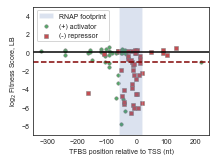

In [46]:
sns.set_style("white")
fig = plt.figure(figsize = (80/25.4, 60/25.4))

df_plot = df_TFBSpromFit_singleTFpromoter_LBEss[df_TFBSpromFit_singleTFpromoter_LBEss['ET165_LB_ae_t0'] >= 10]

df_plot_P = df_plot[df_plot['Gene expression effect from TF binding'] == '+']
df_plot_M = df_plot[df_plot['Gene expression effect from TF binding'] == '-']
df_plot_PM = df_plot[df_plot['Gene expression effect from TF binding'] == '+-']

x_label = 'TFBS position relative to TSS (nt)'
y_label = 'log$_2$ Fitness Score, LB'

ax = fig.add_subplot(1,1,1)
plt.scatter(df_plot_P['TFBSposfromTSS'], df_plot_P['LB_an_avgLR_nmed'], 
                            color = sns.color_palette('deep')[2], label = '(+) activator', s =  12, edgecolor = 'gray', linewidth = 0.5)
plt.scatter(df_plot_M['TFBSposfromTSS'], df_plot_M['LB_an_avgLR_nmed'],
                            color = sns.color_palette('deep')[3], label = '(-) repressor', s =  12, marker = 's', edgecolor = 'gray', linewidth = 0.5)
#plt.xlim([-450, 300])
plt.ylim([-9,5])
ax.axhline(y = 0, color = 'k')
ax.axhline(y = -1, linestyle = '--', color = 'maroon')
ax.axvspan(xmin = -60, xmax = 20, alpha = 0.2, label = 'RNAP footprint', facecolor = sns.color_palette('deep')[0])
plt.xlabel(x_label, fontsize = 7)
plt.ylabel(y_label, fontsize = 7)
plt.legend(loc = 'upper left', fontsize = 7,frameon = True)
plt.tick_params('both', labelsize = 7)

ax.get_xaxis().set_tick_params(direction='in', width=0, length = 0)
ax.get_yaxis().set_tick_params(direction='in', width=0, length = 0)

plt.savefig('Section 5_TFBS/SuppFig_TFBSFitvsPosRelTSS_singlepromoter_LB.pdf', type = 'pdf')

#### Data Table

In [47]:
df_SuppFig13_left = df_TFBSpromFit_singleTFpromoter_LBEss[df_TFBSpromFit_singleTFpromoter_LBEss['ET165_LB_ae_t0'] >= 10].copy()
df_SuppFig13_left = df_SuppFig13_left[df_SuppFig13_left['Gene expression effect from TF binding'].isin(['+','-'])]
sel_cols = ['seq', 'UniqueTF', 'Promoter', 'Gene expression effect from TF binding', 'TFBSposfromTSS', 'FlatList_GenesInTu', 'LB_ae_avgLR_nmed']
df_SuppFig13_left = df_SuppFig13_left[sel_cols].reset_index(drop=True)
dict_colnames = {'seq':'sgRNA sequence', 'UniqueTF':'TF', 'TFBSposfromTSS':'TFBS position relative to TSS (nt)', 
                 'FlatList_GenesInTu':'Genes in TU', 'LB_ae_avgLR_nmed':'log$_2$ Fitness Score, LB'}
df_SuppFig13_left = df_SuppFig13_left.rename(columns=dict_colnames)
df_SuppFig13_left

,sgRNA sequence,TF,Promoter,Gene expression effect from TF binding,TFBS position relative to TSS (nt),Genes in TU,"log$_2$ Fitness Score, LB"
0,cagggagggatatcagtgaa,ArgP,['dapBp1'],+,-81.5,[dapB],-0.152973
1,gatttacgtcactctttatt,TyrR,['folAp'],+,-148.5,[folA],0.215350
2,cattgtaatgcggcgagtcc,TyrR,['folAp'],+,-106.0,[folA],-0.132990
3,attgtaatgcggcgagtcca,TyrR,['folAp'],+,-106.0,[folA],-1.146297
4,gcgagtccagggagagagcg,TyrR,['folAp'],+,-106.0,[folA],-0.581181
...,...,...,...,...,...,...,...
81,tatacagcaaaaggcgattt,LexA,['lexAp'],-,-9.0,"[dinF, lexA]",-5.322779
82,ctgtgagtatatacagcaaa,LexA,['lexAp'],-,-9.0,"[dinF, lexA]",-3.208152
83,gcataactgtatatacaccc,LexA,['lexAp'],-,13.0,"[dinF, lexA]",-0.666674
84,cataactgtatatacaccca,LexA,['lexAp'],-,13.0,"[dinF, lexA]",-0.805693


### M9 Essential Genes

#### Process

In [48]:
df_TFBSpromFit_singleTFpromoter_M9Ess = df_TFBSpromFit[(df_TFBSpromFit['EssGeneTFReg_M9'] > 0) & (df_TFBSpromFit['#Promoters'] < 2)]
df_TFBSpromFit_singleTFpromoter_M9Ess['TFBSposfromTSS'] = df_TFBSpromFit_singleTFpromoter_M9Ess['TFBSposfromTSS'].apply(lambda x: x[0])

#### Visualization

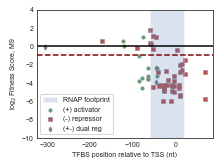

In [49]:
sns.set_style("white")
fig = plt.figure(figsize = (80/25.4, 60/25.4))

df_plot = df_TFBSpromFit_singleTFpromoter_M9Ess[df_TFBSpromFit_singleTFpromoter_M9Ess['ET165_LB_ae_t0'] >= 10]
#df_plot = df_plot[df_plot['TFname'] != ['GlpR']]
df_plot = df_plot[~df_plot['TFname'].apply(lambda x: 'GlpR' in x)]

df_plot_P = df_plot[df_plot['Gene expression effect from TF binding'] == '+']
df_plot_M = df_plot[df_plot['Gene expression effect from TF binding'] == '-']
df_plot_PM = df_plot[df_plot['Gene expression effect from TF binding'] == '+-']

x_label = 'TFBS position relative to TSS (nt)'
y_label = 'log$_2$ Fitness Score, M9'

ax = fig.add_subplot(1,1,1)
plt.scatter(df_plot_P['TFBSposfromTSS'], df_plot_P['M9_ae_avgLR_nmed'], 
                            color = sns.color_palette('deep')[2], label = '(+) activator', s =  12, edgecolor = 'gray', linewidth = 0.5)
plt.scatter(df_plot_M['TFBSposfromTSS'], df_plot_M['M9_ae_avgLR_nmed'],
                            color = sns.color_palette('deep')[3], label = '(-) repressor', s =  12, marker = 's', edgecolor = 'gray', linewidth = 0.5)
plt.scatter(df_plot_PM['TFBSposfromTSS'], df_plot_PM['M9_ae_avgLR_nmed'],
                            color = 'gray', label = '(+-) dual reg', s =  12, marker = 'd')

#plt.xlim([-450, 300])
plt.ylim([-10,4])
ax.axhline(y = 0, color = 'k')
ax.axhline(y = -1, linestyle = '--', color = 'maroon')
ax.axvspan(xmin = -60, xmax = 20, alpha = 0.2, label = 'RNAP footprint', facecolor = sns.color_palette('deep')[0])
plt.xlabel(x_label, fontsize = 7)
plt.ylabel(y_label, fontsize = 7)
plt.legend(loc = 'lower left', fontsize = 7,frameon = True)
plt.tick_params('both', labelsize = 7)

ax.get_xaxis().set_tick_params(direction='in', width=0, length = 0)
ax.get_yaxis().set_tick_params(direction='in', width=0, length = 0)

plt.savefig('Section 5_TFBS/SuppFig_TFBSFitvsPosRelTSS_singlepromoter_M9.pdf', type = 'pdf')

#### Data Table

In [50]:
df_SuppFig13_right = df_TFBSpromFit_singleTFpromoter_LBEss[df_TFBSpromFit_singleTFpromoter_LBEss['ET165_LB_ae_t0'] >= 10].copy()
df_SuppFig13_right = df_SuppFig13_right[df_SuppFig13_right['Gene expression effect from TF binding'].isin(['+','-'])]
sel_cols = ['seq', 'UniqueTF', 'Promoter', 'Gene expression effect from TF binding', 'TFBSposfromTSS', 'FlatList_GenesInTu', 'M9_ae_avgLR_nmed']
df_SuppFig13_right = df_SuppFig13_right[sel_cols].reset_index(drop=True)
dict_colnames = {'seq':'sgRNA sequence', 'UniqueTF':'TF', 'TFBSposfromTSS':'TFBS position relative to TSS (nt)', 
                 'FlatList_GenesInTu':'Genes in TU', 'M9_ae_avgLR_nmed':'log$_2$ Fitness Score, M9'}
df_SuppFig13_right = df_SuppFig13_right.rename(columns=dict_colnames)
df_SuppFig13_right

,sgRNA sequence,TF,Promoter,Gene expression effect from TF binding,TFBS position relative to TSS (nt),Genes in TU,"log$_2$ Fitness Score, M9"
0,cagggagggatatcagtgaa,ArgP,['dapBp1'],+,-81.5,[dapB],0.156172
1,gatttacgtcactctttatt,TyrR,['folAp'],+,-148.5,[folA],1.226006
2,cattgtaatgcggcgagtcc,TyrR,['folAp'],+,-106.0,[folA],0.342495
3,attgtaatgcggcgagtcca,TyrR,['folAp'],+,-106.0,[folA],-0.994777
4,gcgagtccagggagagagcg,TyrR,['folAp'],+,-106.0,[folA],0.181571
...,...,...,...,...,...,...,...
81,tatacagcaaaaggcgattt,LexA,['lexAp'],-,-9.0,"[dinF, lexA]",-5.315158
82,ctgtgagtatatacagcaaa,LexA,['lexAp'],-,-9.0,"[dinF, lexA]",-5.277683
83,gcataactgtatatacaccc,LexA,['lexAp'],-,13.0,"[dinF, lexA]",-0.955825
84,cataactgtatatacaccca,LexA,['lexAp'],-,13.0,"[dinF, lexA]",-1.490030


### Data Export

In [51]:
df_SuppFig13 = pd.concat([df_SuppFig13_left, df_SuppFig13_right], axis=0).reset_index(drop=True)
df_SuppFig13.to_excel('Section 5_TFBS/Table_SuppFig-13.xlsx')
df_SuppFig13

,sgRNA sequence,TF,Promoter,Gene expression effect from TF binding,TFBS position relative to TSS (nt),Genes in TU,"log$_2$ Fitness Score, LB","log$_2$ Fitness Score, M9"
0,cagggagggatatcagtgaa,ArgP,['dapBp1'],+,-81.5,[dapB],-0.152973,NaN
1,gatttacgtcactctttatt,TyrR,['folAp'],+,-148.5,[folA],0.215350,NaN
2,cattgtaatgcggcgagtcc,TyrR,['folAp'],+,-106.0,[folA],-0.132990,NaN
3,attgtaatgcggcgagtcca,TyrR,['folAp'],+,-106.0,[folA],-1.146297,NaN
4,gcgagtccagggagagagcg,TyrR,['folAp'],+,-106.0,[folA],-0.581181,NaN
...,...,...,...,...,...,...,...,...
167,tatacagcaaaaggcgattt,LexA,['lexAp'],-,-9.0,"[dinF, lexA]",NaN,-5.315158
168,ctgtgagtatatacagcaaa,LexA,['lexAp'],-,-9.0,"[dinF, lexA]",NaN,-5.277683
169,gcataactgtatatacaccc,LexA,['lexAp'],-,13.0,"[dinF, lexA]",NaN,-0.955825
170,cataactgtatatacaccca,LexA,['lexAp'],-,13.0,"[dinF, lexA]",NaN,-1.490030


## Feature cofitness of cydD gene, promoter, and TFBS-targeting sgRNAs

### Browser view (LB Aerobic; top)

#### Annotation info

In [52]:
928419-929196, 930308-931085

(-777, -777)

#### Visualization

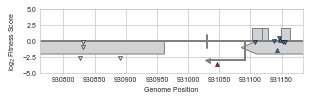

In [53]:
sns.set_style('whitegrid')
fig = plt.figure(figsize = (120/25.4, 30/25.4))
plt.rcParams["font.family"] = "Arial"
ax = fig.add_subplot(1,1,1)
ax.axhline(y = 0, color = 'gray', lw = 2)

gene0 = 'cydC'
gene1 = 'cydD'
gene2 = 'trxB'
TU = "['cydDC']"
list_promoters = ['cydDp']
condition = 'LB_ae_avgLR_nmed'
t0_col = dict_condition_t0[condition]
df_filt = df_LRs_GEq_2e6_nmed_selcols[df_LRs_GEq_2e6_nmed_selcols[t0_col] >= 10]
dict_sgRNA_cydDC_LRs_LB = {}

annotation_offset = 777

list_genes = [gene0, gene1, gene2]
colors = ['#D1D2D4', '#D1D2D4', '#D1D2D4']

###Draw gene graphics
dict_genes_coords = {gene:GeneSet[GeneSet['(2) Gene name'] == gene] for gene in list_genes}

i = 0
for gene in list_genes:
    df = dict_genes_coords[gene]
    plot_gene_patch_2(df, ax, colors[i])
    plt.ylim([-5,5])
    i+=1

plt.xlim([dict_genes_coords[gene1]['(5) Gene_pos_right'].values - 200, dict_genes_coords[gene2]['(4) Gene_pos_left'].values + 100])

###Plot gene sgRNAs
dict_genes_data = {gene:df_LRs_GEq_2e6_nmed_selcols[df_LRs_GEq_2e6_nmed_selcols['gene_name_F2'] == gene] for gene in list_genes}

#print '***gene sgRNAs'
i = 0
for gene in list_genes:
    df = dict_genes_data[gene]
    for sgRNA in df.index:
        #print sgRNA
        #print df_LRs_GEq_2e6_nmed_selcols.loc[sgRNA][t0_col]
        if sgRNA in df_filt.index:
            #print 'pass'
            plot_gene_sgRNAs(sgRNA, condition)
            dict_sgRNA_cydDC_LRs_LB[sgRNA] = [condition, 'gene', gene, df_filt.loc[sgRNA][condition]]
        #else:
            #print 'fail'
    i += 1

###Plot promoter graphics and sgRNAs
#print
#print '***promoter sgRNAs'
for promoter in list_promoters:
    if len(df_map_ann_PromInTUSet_dropnapromotername[(df_map_ann_PromInTUSet_dropnapromotername['(2) Promoter Name'].str.contains(promoter))]) > 0:
        df = df_map_ann_PromInTUSet_dropnapromotername[(df_map_ann_PromInTUSet_dropnapromotername['(2) Promoter Name'].str.contains(promoter))].reset_index()
        plot_promoter_patch(df, ax, 5)
        ax.axvline(x = df['(4) Genome map position of TSS (+1)'].unique(), ymin = 4/10, ymax = 6/10, color = 'gray', linewidth = 2)
        
        for sgRNA in df['sgRNA seq'].unique():
            #print sgRNA
            #print df_LRs_GEq_2e6_nmed_selcols.loc[sgRNA][t0_col]
            if sgRNA in df_filt.index:
                #print 'pass'
                plot_promoter_sgRNAs(sgRNA, condition)
                dict_sgRNA_cydDC_LRs_LB[sgRNA] = [condition, 'promoter', promoter, df_filt.loc[sgRNA][condition]]
            #else:
                #print 'fail'

####Plot TFBS graphics
df_TFBS = get_TFBS_info(TU)
df_TFBS_annot = get_TFBS_annot(TU)

for ECK in df_TFBS_annot['(3) TF binding site (TF-bs) identifier assigned by RegulonDB'].unique():
    effect = plot_TFBS_patch_v3(ECK, ax, 0, 'forward')

####Plot TFBS sgRNAs
#print
#print '***TFBS sgRNAs'
for sgRNA in df_TFBS.index:
    #print sgRNA
    #print df_LRs_GEq_2e6_nmed_selcols.loc[sgRNA][t0_col]
    if sgRNA in df_filt.index:
        #print 'pass'
        plot_TFBS_sgRNAs(sgRNA, condition)
        dict_sgRNA_cydDC_LRs_LB[sgRNA] = [condition, 'TFBS', df_TFBS.loc[sgRNA]['TFname'], df_filt.loc[sgRNA][condition]]
    #else:
        #print 'fail'
        
plt.xlabel('Genome Position', fontsize = 7)
plt.ylabel('log$_2$ Fitness Score', fontsize = 7)
plt.tick_params('both', labelsize = 7)
ax.get_xaxis().set_tick_params(direction='in', width=0)
ax.get_yaxis().set_tick_params(direction='in', width=0)

plt.savefig('Section 5_TFBS/SuppFig_TU_cydDC_LB_ae.pdf', type = 'pdf')

### Browser view (LB Anaerobic; bot)

#### Visualization

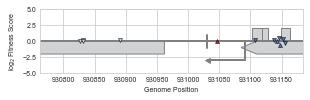

In [54]:
sns.set_style('whitegrid')
fig = plt.figure(figsize = (120/25.4, 30/25.4))
plt.rcParams["font.family"] = "Arial"
ax = fig.add_subplot(1,1,1)
ax.axhline(y = 0, color = 'gray', lw = 2)

gene0 = 'cydC'
gene1 = 'cydD'
gene2 = 'trxB'
TU = "['cydDC']"
list_promoters = ['cydDp']
condition = 'LB_an_avgLR_nmed'
t0_col = dict_condition_t0[condition]
df_filt = df_LRs_GEq_2e6_nmed_selcols[df_LRs_GEq_2e6_nmed_selcols[t0_col] >= 10]
dict_sgRNA_cydDC_LRs_LBan = {}

annotation_offset = 777

list_genes = [gene0, gene1, gene2]
colors = ['#D1D2D4', '#D1D2D4', '#D1D2D4']

###Draw gene graphics
dict_genes_coords = {gene:GeneSet[GeneSet['(2) Gene name'] == gene] for gene in list_genes}

i = 0
for gene in list_genes:
    df = dict_genes_coords[gene]
    plot_gene_patch_2(df, ax, colors[i])
    plt.ylim([-5,5])
    i+=1

plt.xlim([dict_genes_coords[gene1]['(5) Gene_pos_right'].values - 200, dict_genes_coords[gene2]['(4) Gene_pos_left'].values + 100])

###Plot gene sgRNAs
dict_genes_data = {gene:df_LRs_GEq_2e6_nmed_selcols[df_LRs_GEq_2e6_nmed_selcols['gene_name_F2'] == gene] for gene in list_genes}

#print '***gene sgRNAs'
i = 0
for gene in list_genes:
    df = dict_genes_data[gene]
    for sgRNA in df.index:
        #print sgRNA
        #print df_LRs_GEq_2e6_nmed_selcols.loc[sgRNA][t0_col]
        if sgRNA in df_filt.index:
            #print 'pass'
            plot_gene_sgRNAs(sgRNA, condition)
            dict_sgRNA_cydDC_LRs_LBan[sgRNA] = [condition, 'gene', gene, df_filt.loc[sgRNA][condition]]
        #else:
            #print 'fail'
    i += 1

###Plot promoter graphics and sgRNAs
#print
#print '***promoter sgRNAs'
for promoter in list_promoters:
    if len(df_map_ann_PromInTUSet_dropnapromotername[(df_map_ann_PromInTUSet_dropnapromotername['(2) Promoter Name'].str.contains(promoter))]) > 0:
        df = df_map_ann_PromInTUSet_dropnapromotername[(df_map_ann_PromInTUSet_dropnapromotername['(2) Promoter Name'].str.contains(promoter))].reset_index()
        plot_promoter_patch(df, ax, 5)
        ax.axvline(x = df['(4) Genome map position of TSS (+1)'].unique(), ymin = 4/10, ymax = 6/10, color = 'gray', linewidth = 2)
        
        for sgRNA in df['sgRNA seq'].unique():
            #print sgRNA
            #print df_LRs_GEq_2e6_nmed_selcols.loc[sgRNA][t0_col]
            if sgRNA in df_filt.index:
                #print 'pass'
                plot_promoter_sgRNAs(sgRNA, condition)
                dict_sgRNA_cydDC_LRs_LBan[sgRNA] = [condition, 'promoter', promoter, df_filt.loc[sgRNA][condition]]
            #else:
                #print 'fail'

####Plot TFBS graphics
df_TFBS = get_TFBS_info(TU)
df_TFBS_annot = get_TFBS_annot(TU)

for ECK in df_TFBS_annot['(3) TF binding site (TF-bs) identifier assigned by RegulonDB'].unique():
    effect = plot_TFBS_patch_v3(ECK, ax, 0, 'forward')

####Plot TFBS sgRNAs
#print
#print '***TFBS sgRNAs'
for sgRNA in df_TFBS.index:
    #print sgRNA
    #print df_LRs_GEq_2e6_nmed_selcols.loc[sgRNA][t0_col]
    if sgRNA in df_filt.index:
        #print 'pass'
        plot_TFBS_sgRNAs(sgRNA, condition)
        dict_sgRNA_cydDC_LRs_LBan[sgRNA] = [condition, 'TFBS', df_TFBS.loc[sgRNA]['TFname'], df_filt.loc[sgRNA][condition]]
    #else:
        #print 'fail'
        
plt.xlabel('Genome Position', fontsize = 7)
plt.ylabel('log$_2$ Fitness Score', fontsize = 7)
plt.tick_params('both', labelsize = 7)
ax.get_xaxis().set_tick_params(direction='in', width=0)
ax.get_yaxis().set_tick_params(direction='in', width=0)

plt.savefig('Section 5_TFBS/SuppFig_TU_cydDC_LB_an.pdf', type = 'pdf')

### LB Aerobic vs Anaerobic comparison (right)

#### Process

In [55]:
# Aerobic
df_cydDC_LB = pd.DataFrame(dict_sgRNA_cydDC_LRs_LB)
df_cydDC_LB = df_cydDC_LB.transpose()
df_cydDC_LB.columns = ['condition', 'category', 'feature name', 'Fitness (LB)']

# Anaerobic
df_cydDC_LBan = pd.DataFrame(dict_sgRNA_cydDC_LRs_LBan)
df_cydDC_LBan = df_cydDC_LBan.transpose()
df_cydDC_LBan.columns = ['condition', 'category', 'feature name', 'Fitness (LBan)']


In [56]:
df_cydDC_LBaean = pd.concat([df_cydDC_LB, df_cydDC_LBan], axis = 1)
df_cydDC_LBaean = df_cydDC_LBaean.loc[:,~df_cydDC_LBaean.columns.duplicated()]
df_cydDC_LBaean

,condition,category,feature name,Fitness (LB),Fitness (LBan)
tgaggccgagaggaaccagc,LB_ae_avgLR_nmed,gene,cydC,-3.69839,0.101281
aagtgtcaacagaccgatac,LB_ae_avgLR_nmed,gene,cydC,-5.98514,-6.80145
acgtttatacagtgccagat,LB_ae_avgLR_nmed,gene,cydC,-4.06941,0.0555285
cgtttatacagtgccagata,LB_ae_avgLR_nmed,gene,cydC,-3.86087,0.364534
cagaattcgcgccatgaacc,LB_ae_avgLR_nmed,gene,cydD,-2.66537,0.0160341
ttcgcgccatgaaccaggcc,LB_ae_avgLR_nmed,gene,cydD,-0.0748465,0.251065
tcgcgccatgaaccaggcct,LB_ae_avgLR_nmed,gene,cydD,-0.851938,0.0206761
gagaaatattcagccaacgt,LB_ae_avgLR_nmed,gene,cydD,-2.542,0.142904
acagcagcggtgtatcccgc,LB_ae_avgLR_nmed,gene,trxB,-0.669433,0.11314
cagcagcggtgtatcccgcc,LB_ae_avgLR_nmed,gene,trxB,-0.416624,0.251608


#### Visualize

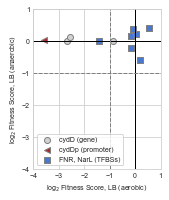

In [57]:
sns.set_style('whitegrid')
fig = plt.figure(figsize = (58/25.4, 74.5/25.4))
plt.rcParams["font.family"] = "Arial"
ax = fig.add_subplot(1,1,1)

x = df_cydDC_LBaean[df_cydDC_LBaean['category'] == 'gene']
x_upstream = x[x['feature name'] == 'trxB']
x = df_cydDC_LBaean[df_cydDC_LBaean['feature name'] == 'cydD']
x = x[x['feature name'] != 'trxB']
y = df_cydDC_LBaean[df_cydDC_LBaean['category'] == 'promoter']
z = df_cydDC_LBaean[df_cydDC_LBaean['category'] == 'TFBS']

ax.axvline(x=0,linestyle = '-', color = 'k',linewidth = 1)
ax.axhline(y=0,linestyle = '-', color = 'k',linewidth = 1)
ax.axvline(x=-1,linestyle = '--', color = 'gray',linewidth = 1)
ax.axhline(y=-1,linestyle = '--', color = 'gray',linewidth = 1)

plt.scatter(x['Fitness (LB)'], x['Fitness (LBan)'], color = '#D1D2D4', marker = 'o',
            label = 'cydD (gene)', edgecolor = 'gray', alpha = 1)
plt.scatter(y['Fitness (LB)'], y['Fitness (LBan)'], color = '#AE282B', marker = '<',
            label = 'cydDp (promoter)', edgecolor = 'gray', alpha = 1)
plt.scatter(z['Fitness (LB)'], z['Fitness (LBan)'], color = sns.color_palette('muted')[0], 
            marker = 's', label = 'FNR, NarL (TFBSs)', edgecolor = 'gray', alpha = 1)

plt.xlim([-4,1])
plt.ylim([-4,1])
plt.xlabel('log$_2$ Fitness Score, LB (aerobic)', fontsize = 7)
plt.ylabel('log$_2$ Fitness Score, LB (anaerobic)', fontsize = 7)
plt.tick_params('both', labelsize = 7)

plt.legend(loc = 'lower left', fontsize = 7, scatterpoints = 1, frameon = True)
ax.get_xaxis().set_tick_params(direction='in', width=0)
ax.get_yaxis().set_tick_params(direction='in', width=0)

plt.savefig('Section 5_TFBS/SuppFig_TU_cydD_LBaevsan_scatterplot.pdf', type = 'pdf')

### Data Export

In [58]:
df_SupFig14 = df_cydDC_LBaean.reset_index(drop=False)
df_SupFig14 = df_SupFig14.rename(columns={'index':'sgRNA seq', 
                                          'Fitness (LB)':'Fitness, LB (aerobic)',
                                          'Fitness (LBan)':'Fitness, LB (anaerobic)'})
df_SupFig14 = df_SupFig14.drop(columns='condition')
df_SupFig14.to_excel('Section 5_TFBS/Table_SuppFig-14.xlsx')
df_SupFig14

,sgRNA seq,category,feature name,"Fitness, LB (aerobic)","Fitness, LB (anaerobic)"
0,tgaggccgagaggaaccagc,gene,cydC,-3.69839,0.101281
1,aagtgtcaacagaccgatac,gene,cydC,-5.98514,-6.80145
2,acgtttatacagtgccagat,gene,cydC,-4.06941,0.0555285
3,cgtttatacagtgccagata,gene,cydC,-3.86087,0.364534
4,cagaattcgcgccatgaacc,gene,cydD,-2.66537,0.0160341
5,ttcgcgccatgaaccaggcc,gene,cydD,-0.0748465,0.251065
6,tcgcgccatgaaccaggcct,gene,cydD,-0.851938,0.0206761
7,gagaaatattcagccaacgt,gene,cydD,-2.542,0.142904
8,acagcagcggtgtatcccgc,gene,trxB,-0.669433,0.11314
9,cagcagcggtgtatcccgcc,gene,trxB,-0.416624,0.251608
